In [1]:
# ===========================================
# 1️⃣ INSTALL LIBRARIES
# ===========================================
!pip install -q transformers datasets torchaudio librosa soundfile scikit-learn kaggle



In [2]:
# ===========================================
# 2️⃣ IMPORTS
# ===========================================
import os
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from datasets import Dataset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    Trainer,
    TrainingArguments
)


In [3]:
# ===========================================
# 3️⃣ UPLOAD kaggle.json
# ===========================================
from google.colab import files
files.upload()   # Upload your kaggle.json file here



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ankitkumariiserb","key":"42185780710c144e0e7e81911a15616a"}'}

In [4]:
# ===========================================
# 4️⃣ CONFIGURE KAGGLE
# ===========================================
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
# ===========================================
# 5️⃣ DOWNLOAD & EXTRACT TESS DATASET
# ===========================================
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!unzip -q toronto-emotional-speech-set-tess.zip -d /content/TESS
data_dir = "/content/TESS"



Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 97% 416M/428M [00:00<00:00, 392MB/s]
100% 428M/428M [00:00<00:00, 472MB/s]


In [6]:
# ===========================================
# 6️⃣ PREPARE FILES AND LABELS
# ===========================================
emotion_labels = ["angry","disgust","fear","happy","neutral","ps","sad","surprise"]
files, y = [], []

base_dir = "/content/TESS/TESS Toronto emotional speech set data"
for root, _, fns in os.walk(base_dir):
    for f in fns:
        if f.endswith(".wav"):
            folder_name = os.path.basename(root).lower()
            for idx, emotion in enumerate(emotion_labels):
                if emotion in folder_name:
                    files.append(os.path.join(root, f))
                    y.append(idx)
                    break

print("✅ Total audio files found:", len(files))

# Use only 1400 samples for fast training
files, y = files[:1400], y[:1400]
print("✅ Using subset:", len(files))





✅ Total audio files found: 2800
✅ Using subset: 1400


In [7]:
# ===========================================
# 7️⃣ CREATE DATASET
# ===========================================
dataset = Dataset.from_dict({"path": files, "label": y})
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [8]:
# ===========================================
# 8️⃣ PREPROCESS FUNCTION
# ===========================================
def preprocess(batch):
    speech, sr = torchaudio.load(batch["path"])
    speech = torchaudio.transforms.Resample(sr, 16000)(speech)
    inputs = processor(
        speech.squeeze().numpy(),
        sampling_rate=16000,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=16000 * 4
    )
    return {"input_values": inputs.input_values[0], "labels": torch.tensor(batch["label"])}

dataset = dataset.map(preprocess)


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

In [9]:
# ===========================================
# 9️⃣ TRAIN / TEST SPLIT
# ===========================================
split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, eval_dataset = split["train"], split["test"]

def collate_fn(batch):
    input_values = [x["input_values"] for x in batch]
    labels = [x["labels"] for x in batch]
    batch_inputs = processor.pad({"input_values": input_values}, padding=True, return_tensors="pt")
    batch_inputs["labels"] = torch.tensor(labels)
    return batch_inputs


In [17]:
# ===========================================
# 🔟 LOAD MODEL
# ===========================================
from transformers import Wav2Vec2ForSequenceClassification

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=len(emotion_labels),
    label2id={l:i for i,l in enumerate(emotion_labels)},
    id2label={i:l for i,l in enumerate(emotion_labels)}
)

# 1️⃣ Freeze all encoder parameters first
for param in model.wav2vec2.parameters():
    param.requires_grad = False

# 2️⃣ Unfreeze the last two encoder layers (fine-tune only these)
for name, param in model.wav2vec2.named_parameters():
    if "encoder.layers.10" in name or "encoder.layers.11" in name:
        param.requires_grad = True

print("✅ Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))



/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Trainable params: 14374664


In [19]:
# ===========================================
# 1️⃣1️⃣ TRAINING ARGUMENTS
# ===========================================
training_args = TrainingArguments(
    output_dir="./wav2vec2-tess",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=10,    # instead of 3
    learning_rate=1e-4,     # slightly lower for stability
    fp16=True,
    logging_dir="./logs",
    save_total_limit=1,
    save_strategy="epoch"
)





In [20]:
# ===========================================
# 1️⃣2️⃣ TRAINER SETUP
# ===========================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn
)


In [21]:
# ===========================================
# 1️⃣3️⃣ TRAIN MODEL
# ===========================================
trainer.train()
metrics = trainer.evaluate()
print("📊 Evaluation metrics:", metrics)



Step,Training Loss
500,0.266900
1000,0.001800


📊 Evaluation metrics: {'eval_loss': 0.09640004485845566, 'eval_runtime': 12.3843, 'eval_samples_per_second': 22.609, 'eval_steps_per_second': 5.652, 'epoch': 10.0}


✅ Accuracy: 97.14%


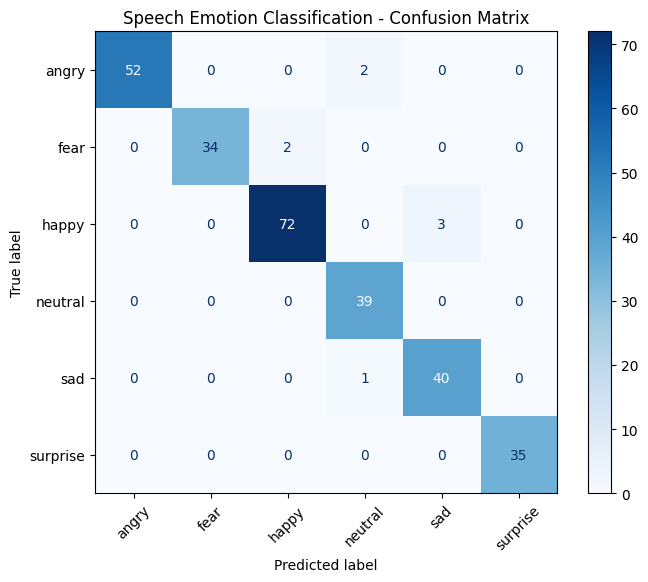

In [22]:
# ===========================================
# 1️⃣4️⃣ CONFUSION MATRIX
# ===========================================
preds_output = trainer.predict(eval_dataset)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"✅ Accuracy: {acc*100:.2f}%")

from sklearn.utils.multiclass import unique_labels

# Filter labels that actually appear
used_labels = unique_labels(y_true, y_pred)
used_emotions = [emotion_labels[i] for i in used_labels]

cm = confusion_matrix(y_true, y_pred, labels=used_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=used_emotions)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.title("Speech Emotion Classification - Confusion Matrix")
plt.show()



In [ ]:
# ===========================================
# 1️⃣5️⃣ SAVE & DOWNLOAD MODEL
# ===========================================
save_dir = "/content/fine_tuned_wav2vec2_tess"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

# Zip and prepare for download
!zip -r fine_tuned_wav2vec2_tess.zip $save_dir
from google.colab import files
files.download("fine_tuned_wav2vec2_tess.zip")


In [ ]:
# ===========================================
# 1️⃣6️⃣ DEMO PREDICTION
# ===========================================
import random

path = random.choice(files)
speech, sr = torchaudio.load(path)
speech = torchaudio.transforms.Resample(sr, 16000)(speech)
inputs = processor(speech.squeeze().numpy(), sampling_rate=16000, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits
pred = torch.argmax(logits, dim=-1).item()

print("🎧 File:", path)
print("🎯 Predicted Emotion:", emotion_labels[pred])

